# Mean Reversion

## Internal Bar Strength

### Theory

**IBS** can in someway predict bullish or bearish movement of feature. It' pretty simple to calculate:
$$
\text{IBS}=\frac{\text{Close}-\text{Low}}{\text{High}-\text{Low}}
$$

$$
\text{IBS} < 0.6 \rightarrow \text{potential bearish sentiment}
$$
$$
\text{IBS} \geq 0.6 \rightarrow \text{potential bullish sentiment}
$$

Bollinger Band integrate historical data to estimate when a mean reversal is probable. Bollinger is using 25-day moving average of high prices and its deviation from the scaled range of high and low moving average prices:

$$
\text{Band} = \text{MA}_{25}(\text{High})-(2.25\cdot\text{HL}_\text{avg})
$$
where
$$
\text{HL}_\text{avg}=\text{MA}_{25}(\text{High})-\text{MA}_{25}(\text{Low})
$$

### Fetch data

In [416]:
import yfinance as yf

ticker = "^GSPC"
# ticker = "META"
def download_data(ticker, period):
    data = yf.download(ticker, period=period, interval="1d", group_by="column")
    data.columns = data.columns.droplevel(1)  # drop second level of MultiIndex
    return data

data = download_data(ticker, "1y")

/var/folders/g3/sxyl_n7x6d51bbb320nhxx5c0000gn/T/ipykernel_1059/2799859362.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, period=period, interval="1d", group_by="column")
[*********************100%***********************]  1 of 1 completed


In [417]:
print(data)

Price             Close         High          Low         Open      Volume
Date                                                                      
2024-08-19  5608.250000  5608.299805  5550.740234  5557.229980  3222050000
2024-08-20  5597.120117  5620.509766  5585.500000  5602.879883  2994420000
2024-08-21  5620.850098  5632.680176  5591.569824  5603.089844  3119670000
2024-08-22  5570.640137  5643.220215  5560.950195  5637.770020  2981530000
2024-08-23  5634.609863  5641.819824  5585.160156  5602.490234  3291940000
...                 ...          ...          ...          ...         ...
2025-08-12  6445.759766  6446.549805  6385.759766  6395.169922  5135300000
2025-08-13  6466.580078  6480.279785  6445.020020  6462.669922  5195950000
2025-08-14  6468.540039  6473.919922  6441.069824  6453.459961  4462050000
2025-08-15  6449.799805  6481.339844  6441.850098  6477.379883  4575060000
2025-08-18  6449.149902  6455.350098  6437.700195  6445.020020  4162290000

[250 rows x 5 columns]


### Prepare data to Bollinger Band

In [418]:
def calculate_indicators(data):
    data['IBS'] = (data['Close'] - data['Low']) / (data['High'] - data['Low'])
    data['HL_avg'] = data['High'].rolling(window=25).mean() - data['Low'].rolling(window=25).mean()
    data['Band'] = data['High'].rolling(window=25).mean() - (2.25 * data['HL_avg'])


In [419]:
calculate_indicators(data)
print(data.tail())

Price             Close         High          Low         Open      Volume  \
Date                                                                         
2025-08-12  6445.759766  6446.549805  6385.759766  6395.169922  5135300000   
2025-08-13  6466.580078  6480.279785  6445.020020  6462.669922  5195950000   
2025-08-14  6468.540039  6473.919922  6441.069824  6453.459961  4462050000   
2025-08-15  6449.799805  6481.339844  6441.850098  6477.379883  4575060000   
2025-08-18  6449.149902  6455.350098  6437.700195  6445.020020  4162290000   

Price            IBS     HL_avg         Band  
Date                                          
2025-08-12  0.987004  47.814395  6239.294409  
2025-08-13  0.611463  47.715586  6247.961514  
2025-08-14  0.836229  47.478379  6255.843218  
2025-08-15  0.201311  47.784375  6263.630723  
2025-08-18  0.648712  47.126777  6272.391919  


### Backtesting strategy

**In this backtesting we are skipping taxes and brokerage commissions.**
1. For loop to simulate every day from 25th day to end of list.
2. If position on market doesn't exist + IBS is below 0.6 and closing price is below Band then buy.
3. If position on market exist + today closing price is higher than High price from yesterday then sell.

In [420]:
import numpy as np
import pandas as pd


def backtest_strategy(data, initial_capital=1000):
    is_position = False
    assets_num = 0
    wallet = initial_capital

    backtesting_data = {'Entry': [np.nan for _ in range(25)], 'Exit': [np.nan for _ in range(25)]}

    for i in range(25, len(data)):
        if not is_position and data['IBS'].iloc[i] < 0.6 and data['Close'].iloc[i] < data['Band'].iloc[i]:
            is_position = True
            assets_num = wallet / data['Close'].iloc[i]
            wallet = 0
            backtesting_data['Entry'].append(data['Close'].iloc[i])
        else:
            backtesting_data['Entry'].append(np.nan)

        if is_position and data['Close'].iloc[i] > data['High'].iloc[i - 1]:
            is_position = False
            wallet = assets_num * data['Close'].iloc[i]
            assets_num = 0
            backtesting_data['Exit'].append(data['Close'].iloc[i])
        else:
            backtesting_data['Exit'].append(np.nan)

    return backtesting_data, wallet


In [421]:
backtesting_data, wallet = backtest_strategy(data)
print(wallet)

1062.6624202600233


In [422]:
print(len(backtesting_data['Entry']), "entries")
print(len(backtesting_data['Exit']), "exits")
print(len(data), "days")

250 entries
250 exits
250 days


### Visualization of Backtesting Results

In [423]:
import mplfinance as mpf


def plot_backtesting_results(data, backtesting_data):
    ap = [
        mpf.make_addplot(backtesting_data['Entry'], type='scatter', markersize=100, marker='^', color='g'),
        mpf.make_addplot(backtesting_data['Exit'], type='scatter', markersize=100, marker='v', color='r')
    ]

    mpf.plot(
        data,
        type='candle',
        addplot=ap,
        volume=False,
        style='yahoo',
        title='Mean Reversion Strategy Backtest',
        tight_layout=True
    )

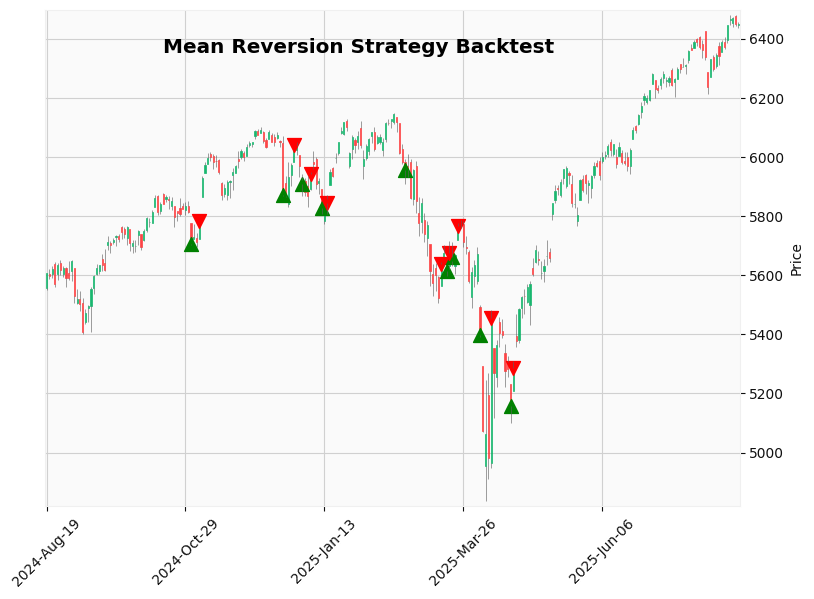

In [424]:
plot_backtesting_results(data, backtesting_data)

## Test strategy on cryptocurrency data

In [425]:
import ccxt

def fetch_crypto_data(symbol, timeframe, since):
    exchange = ccxt.binance()
    ohlcv = exchange.fetch_ohlcv(symbol, timeframe, since=since)
    data = pd.DataFrame(ohlcv, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume'])
    data.rename(columns={
        'timestamp': 'Date',
        'open': 'Open',
        'high': 'High',
        'low': 'Low',
        'close': 'Close',
        'volume': 'Volume'
    }, inplace=True)
    data['Date'] = pd.to_datetime(data['Date'], unit='ms')
    data.set_index('Date', inplace=True)

    return data


In [426]:
crypto_data = fetch_crypto_data('BTC/USDT', '1d', since=ccxt.binance().parse8601('2023-01-01T00:00:00Z'))

In [427]:
calculate_indicators(crypto_data)
print(crypto_data)

                Open      High       Low     Close        Volume       IBS  \
Date                                                                         
2023-01-01  16541.77  16628.00  16499.01  16616.75   96925.41374  0.912784   
2023-01-02  16617.17  16799.23  16548.70  16672.87  121888.57191  0.495629   
2023-01-03  16672.78  16778.40  16605.28  16675.18  159541.53733  0.403766   
2023-01-04  16675.65  16991.87  16652.66  16850.36  220362.18862  0.582825   
2023-01-05  16850.36  16879.82  16753.00  16831.85  163473.56641  0.621747   
...              ...       ...       ...       ...           ...       ...   
2024-05-10  63074.00  63469.13  60187.12  60799.99   36529.34025  0.186736   
2024-05-11  60799.99  61515.00  60487.09  60825.99   13374.56936  0.329698   
2024-05-12  60825.99  61888.00  60610.00  61483.99   12753.13236  0.683873   
2024-05-13  61484.00  63450.00  60749.21  62940.08   32733.41839  0.811196   
2024-05-14  62940.09  63118.36  61142.77  61577.49   29088.72041

In [428]:
crypto_backtesting_data, crypto_wallet = backtest_strategy(crypto_data)

In [429]:
print(crypto_wallet)

1391.3762475198355


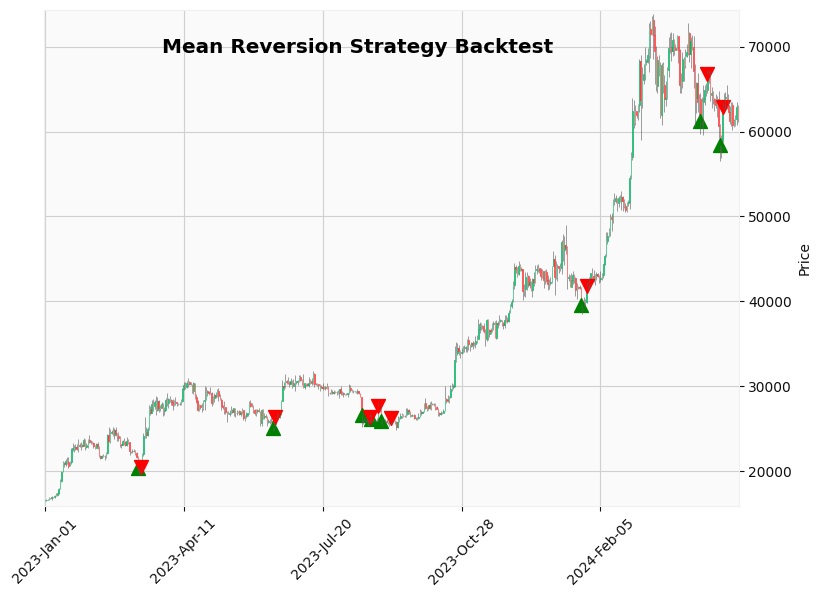

In [430]:
plot_backtesting_results(crypto_data, crypto_backtesting_data)